In [1]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [2]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.5)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []
    
    
    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place
    if random_numbers == [0.3,0.4,0.4]: # make sure final numbers dont appear in the training phase
        random_numbers = generate_random_numbers() 
    
    return random_numbers

In [3]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [4]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [23]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters


total_episodes = 400
total_test_episodes = 50
max_steps = 100
learning_rate = 0.9
gamma = 0.6
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    arr_rates = generate_random_numbers()
    env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        #print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
#         print(reward)
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
Episode  1 / 400
Episode  2 / 400
Episode  3 / 400
Episode  4 / 400
Episode  5 / 400
Episode  6 / 400
Episode  7 / 400
Episode  8 / 400
Episode  9 / 400
Episode  10 / 400
Episode  11 / 400
Episode  12 / 400
Episode  13 / 400
Episode  14 / 400
Episode  15 / 400
Episode  16 / 400
Episode  17 / 400
Episode  18 / 400
Episode  19 / 400
Episode  20 / 400
Episode  21 / 400
Episode  22 / 400
Episode  23 / 400
Episode  24 / 400
Episode  25 / 400
Episode  26 / 400
Episode  27 / 400
Episode  28 / 400
Episode  29 / 400
Episode  30 / 400
Episode  31 / 400
Episode  32 / 400
Episode  33 / 400
Episode  34 / 400
Episode  35 / 400
Episode  36 / 400
Episode  37 / 400
Episode  38 / 400
Episode  39 / 400
Episode  40 / 400
Episode  41 / 400
Episode  42 / 400
Episode  43 / 400
Episode  44 / 400
Episode  45 / 400
Episode  46 / 400
Episode  47 / 400
Episode  48 / 400
Episode  49 / 400
Episode  50 / 400
Episode  51 / 400
Episode  52 / 400
Episode  53 / 400
Episode  54 / 400
Episode  55 / 400
Ep

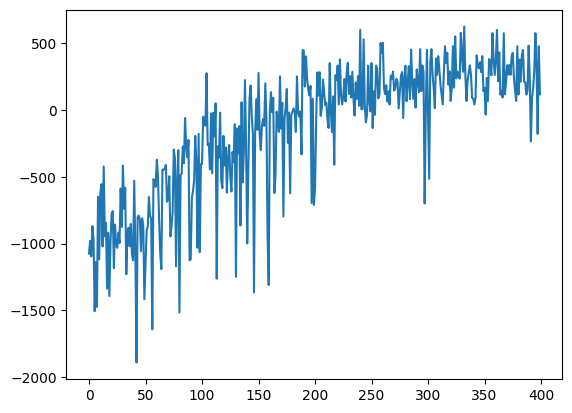

In [24]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [25]:
print(rewardstest)

[-1074, -980, -1096, -869, -966, -1506, -1137, -1474, -649, -1117, -620, -554, -1021, -421, -945, -844, -1337, -918, -1392, -984, -778, -756, -1183, -857, -1008, -1031, -918, -995, -587, -875, -416, -737, -581, -1229, -927, -881, -1020, -852, -1076, -1125, -529, -1054, -1890, -803, -789, -819, -1057, -810, -865, -1417, -1168, -900, -870, -650, -794, -809, -1641, -517, -538, -575, -371, -495, -816, -1073, -1191, -446, -444, -443, -410, -686, -663, -495, -946, -868, -765, -295, -359, -1169, -531, -300, -1516, -488, -475, -272, -397, -59, -275, -352, -223, -1125, -1116, -655, -606, -527, -193, -396, -1031, -177, -1063, -403, -403, -49, -97, -115, 277, -261, -252, -444, -25, -473, -19, -196, 51, -1262, -269, -356, -19, -529, -584, -193, -415, -280, -618, -351, -261, -496, -609, -314, -389, -105, -1248, -137, -323, -119, -864, 59, -542, -311, 225, -276, -998, -425, 83, 185, -41, -179, -1365, -165, 83, -147, 279, -177, -299, -117, -67, -117, 201, -72, -949, -1309, -13, 135, -15, 93, -621, -4

In [26]:
# Play the Game
env = TrafficGenerator(0.3,0.25,0.4)

def test_model():
    rewards = []
    for episode in range(total_test_episodes):
        total_rewards = 0
        total_penalties = 0

        state = env.reset()
    #     print('='*40)
    #     print("[*] Episode", episode)
    #     print('='*40)

        for step in range(max_steps):
            env.render()
            action = np.argmax(qtable[state, :])
            state, reward, done, info = env.step(action)
    #         print(reward)
            """"
            if reward == -10:
                total_penalties += 1
            else:
                total_rewards += reward
            """
            total_rewards += reward
            #print("total time: {}", env.totaltime)
            if done:
                rewards.append(total_rewards)
                break
    print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

for i in range(10):
    test_model()
env.close()


[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
[*] Average Score: 267.0
